In [26]:
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import *

import numpy as np
import tensorflow as tf

from IPython.display import clear_output
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import torch
import keras
import datetime
import time

In [27]:
env = gym.make('MountainCar-v0')

def run_env(policy):
  obs = env.reset()
  a = policy(obs)

  for i in range(1000):
    obs_next, r, done, info = env.step(a)
    a_next = policy(obs_next)
    yield obs, a, r, obs_next, a_next, done
    obs, a = obs_next, a_next
    if done:
      break
  env.close()


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


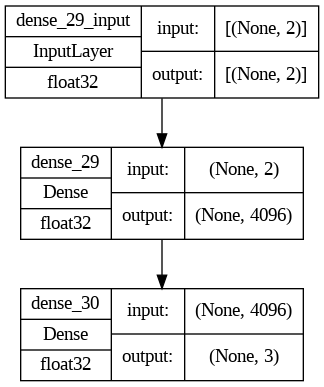

In [50]:
alpha = 0.0001
epsilon = 0.02
gamma = 0.9


p_inputSpace = 2
p_outputSpace = 3

model=Sequential()
model.add(Dense(4096,input_shape=(p_inputSpace,), activation="relu"))
# model.add(Dense(24, activation="relu"))
model.add(Dense(p_outputSpace, activation="linear"))
model.compile()

optimizer=keras.optimizers.Adam(learning_rate=alpha)
f_ppError = keras.losses.MeanSquaredError()

keras.utils.plot_model(
model,
#to_file="model.png",
show_shapes=True,
show_dtype=True,
show_layer_names=True,
rankdir="TB", #TB: vertical; LR: hor
expand_nested=True,
dpi=96,
)


In [38]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16266385271774402576
xla_global_id: -1
]


[200, 200, 200]
2023-08-02 20:20:22.646730


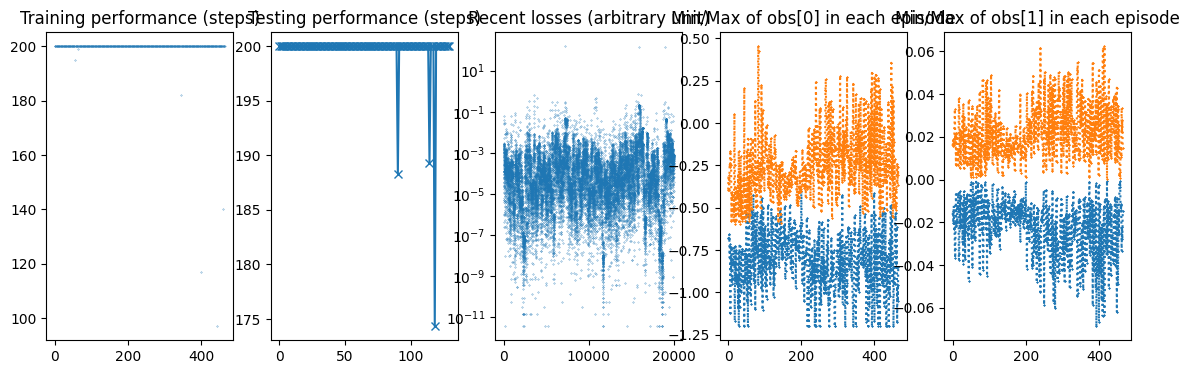

466
200
467
132
Good test performance - stop training
Training finished in 0:37:48.654554


In [51]:
n = 5
rng = np.random.RandomState(1000)

history_steps = []
history_steps_testing = []
history_loss = []
history_states = [[], []]
tic = datetime.datetime.now()
last_plot = time.time()
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
from keras import backend as K
K._get_available_gpus()
def policy_fun(obs, *args, **kwargs):
  if rng.random() < epsilon:
    return env.action_space.sample()
  else:
    predictions = model(obs.reshape((-1,2)))
    return tf.keras.backend.eval(tf.math.argmax(predictions,1))[0]

for episode_i in range(10000):
    # Record steps from the episode yielded by run_env
    episode = []
    print(episode_i)
    # Generate episode
    length = 0
    for t, (s, a, r, s_, a_, done) in enumerate(run_env(policy_fun)):
        length += 1
        if env.spec.id == 'MountainCar-v0':
            r -= 1.0
        if t == 199 and done:
            done = False
        episode.append((s, a, r, s_, a_, done))

        # Update
        tau = t - n + 1
        if tau >= 0:
            S, A, R, S_, R_, DONE = 0, 1, 2, 3, 4, 5

            episode_section = episode[tau:tau+n]
            G = gamma ** np.arange(len(episode_section)) @ [
                i[R] for i in episode_section
            ]
            with tf.GradientTape() as tape:
              predictions = model(s_.reshape((-1,2)), training=True)
              G += (1-episode_section[-1][DONE]) * (gamma ** n) * predictions[0][a_]
              q_pred = model(s.reshape((-1,2)), training=True)[0][a]
              ppError = f_ppError([[G]],[q_pred])
            grads = tape.gradient(ppError,model.trainable_weights)
            optimizer.apply_gradients(zip(grads, model.trainable_weights))

            history_loss.append(ppError)
    print(length)
    if length < 200:
      def policy(o, *_, **__):
            predictions = model(o.reshape((-1,2)))
            return tf.keras.backend.eval(tf.math.argmax(predictions,1))[0]
      test_performance = []
      for i in range(3):
        episode = list(run_env(policy))
        test_performance.append(len(episode))
      test_performance = np.array(test_performance)
      if (((test_performance >= 200).all() and env.spec.id == 'CartPole-v0') or
          ((test_performance < 200).all() and env.spec.id == 'MountainCar-v0')):
          print("Good test performance - stop training")
          print("Training finished in", datetime.datetime.now() - tic)
          break


    history_steps.append(t+1)
    episode_states = np.array([i[S] for i in episode])
    history_states[0].append((episode_states[:,0].min(), episode_states[:,0].max()))
    history_states[1].append((episode_states[:,1].min(), episode_states[:,1].max()))

    if time.time() - last_plot > 15:
        last_plot = time.time()
        clear_output(wait=True)

        # Get testing performance of greedy policy
        test_performance = []
        def policy(o, *_, **__):
            predictions = model(o.reshape((-1,2)))
            return tf.keras.backend.eval(tf.math.argmax(predictions,1))[0]
        for i in range(3):
            episode = list(run_env(policy))
            test_performance.append(len(episode))
        print(test_performance)
        test_performance = np.array(test_performance)
        print(datetime.datetime.now())
        history_steps_testing.append(test_performance.mean())

        # Make plots
        fig, ax = plt.subplots(1, 5, figsize=(14, 4))
        ax[0].plot(history_steps, '.', markersize=0.5)
        ax[0].set_title("Training performance (steps)")
        ax[1].plot(history_steps_testing, '-x')
        ax[1].set_title("Testing performance (steps)")
        ax[2].semilogy(history_loss[-20000:], '.', markersize=0.5)
        ax[2].set_title("Recent losses (arbitrary unit)")
        ax[3].plot(history_states[0], ':x', markersize=1.0)
        ax[3].set_title("Min/Max of obs[0] in each episode")
        ax[4].plot(history_states[1], ':x', markersize=1.0)
        ax[4].set_title("Min/Max of obs[1] in each episode")
        fig.show()
        plt.show()




Testing performance
[143, 146, 140, 140, 140]


Text(0.5, 0, 'Number of steps')

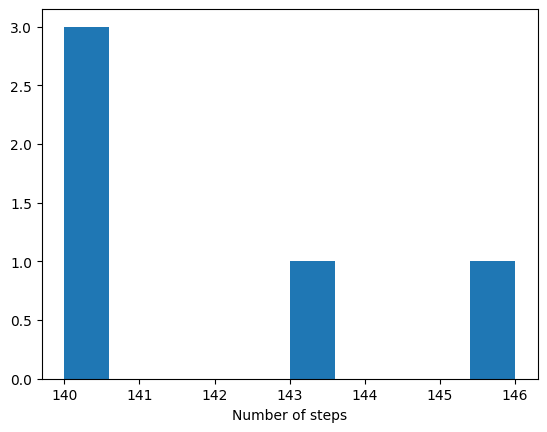

In [52]:
print("Testing performance")
test_performance = []
def policy(o, *_, **__):
    predictions = model(o.reshape((-1,2)))
    return tf.keras.backend.eval(tf.math.argmax(predictions,1))[0]
for i in range(5):
    episode = list(run_env(policy))
    test_performance.append(len(episode))
print(test_performance)
plt.hist(test_performance)
plt.xlabel("Number of steps")